In [3]:
import pandas as pd


expedia_df = pd.read_csv('/content/expidia_filtered_final.csv')
booking_df = pd.read_csv('/content/nyc_hotels_dataProject_filtered.csv')

# Clean up hotel names to avoid matching issues
expedia_df['name'] = expedia_df['name'].str.strip().str.lower()
booking_df['name'] = booking_df['name'].str.strip().str.lower()

# Create a DataFrame that contains only shared hotels with the same TTT and LOS
matched_df = pd.merge(expedia_df[['name', 'ttt', 'los']],
                      booking_df[['name', 'ttt', 'los']],
                      on=['name', 'ttt', 'los'],
                      how='inner')

expedia_matched = expedia_df.merge(matched_df, on=['name', 'ttt', 'los'], how='inner')
expedia_matched.to_csv('/content/matched_expedia.csv', index=False)

booking_matched = booking_df.merge(matched_df, on=['name', 'ttt', 'los'], how='inner')
booking_matched.to_csv('/content/matched_booking.csv', index=False)

print("Files created successfully:")
print("- matched_expedia.csv: Contains only the shared hotels from Expedia")
print("- matched_booking.csv: Contains only the shared hotels from Booking")


Files created successfully:
- matched_expedia.csv: Contains only the shared hotels from Expedia
- matched_booking.csv: Contains only the shared hotels from Booking


In [6]:
import pandas as pd

# Load the cleaned matched datasets
expedia_df = pd.read_csv('/content/matched_expedia.csv')
booking_df = pd.read_csv('/content/matched_booking.csv')

# Rename price columns to distinguish them
expedia_df.rename(columns={'price': 'price_expedia'}, inplace=True)
booking_df.rename(columns={'price': 'price_booking'}, inplace=True)

# Merge based on 'name', 'ttt', and 'los'
merged_prices = pd.merge(
    expedia_df[['name', 'ttt', 'los', 'price_expedia']],
    booking_df[['name', 'ttt', 'los', 'price_booking']],
    on=['name', 'ttt', 'los'],
    how='inner'
)

# Calculate price difference
merged_prices['price_difference'] = merged_prices['price_expedia'] - merged_prices['price_booking']
merged_df = merged_prices.drop_duplicates()
merged_df.to_csv('/content/price_differences.csv', index=False)
print("price_differences.csv")



price_differences.csv


In [7]:
print(f"Number of rows after cleaning: {len(merged_df)}")

Number of rows after cleaning: 10097


## Linear Regression

     Metric         Value
0       MAE     83.743565
1       MSE  18797.879849
2      RMSE    137.105360
3  R² Score      0.826076


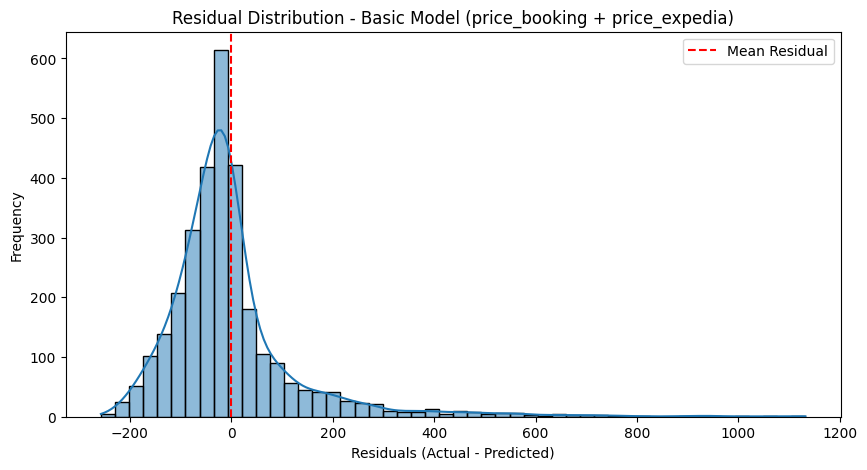

Basic Model (price_booking + price_expedia) 
     Metric         Value
0       MAE    182.531925
1       MSE  97998.678408
2      RMSE    313.047406
3  R² Score      0.093285


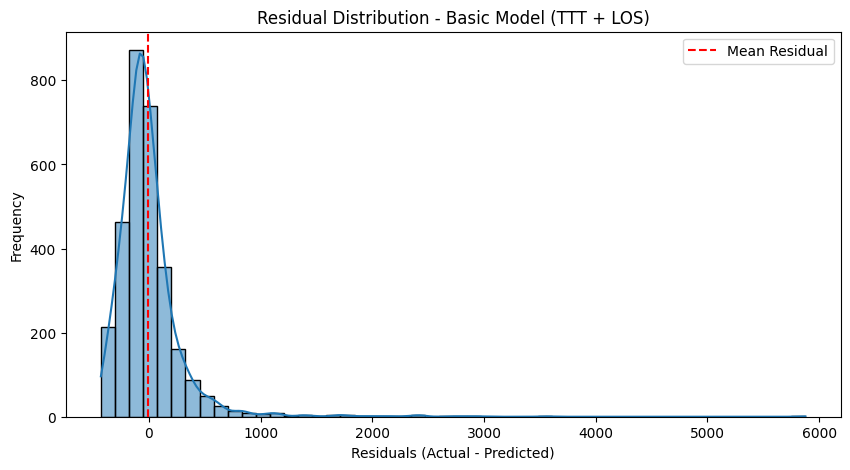

Basic Model (TTT + LOS) 
     Metric         Value
0       MAE     84.386644
1       MSE  18712.796759
2      RMSE    136.794725
3  R² Score      0.826863


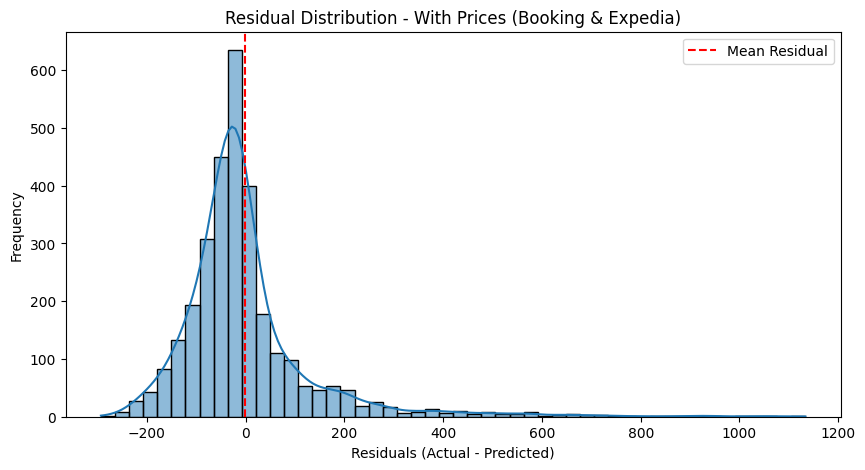

With Prices (Booking & Expedia) 
     Metric         Value
0       MAE     84.386644
1       MSE  18712.796759
2      RMSE    136.794725
3  R² Score      0.826863


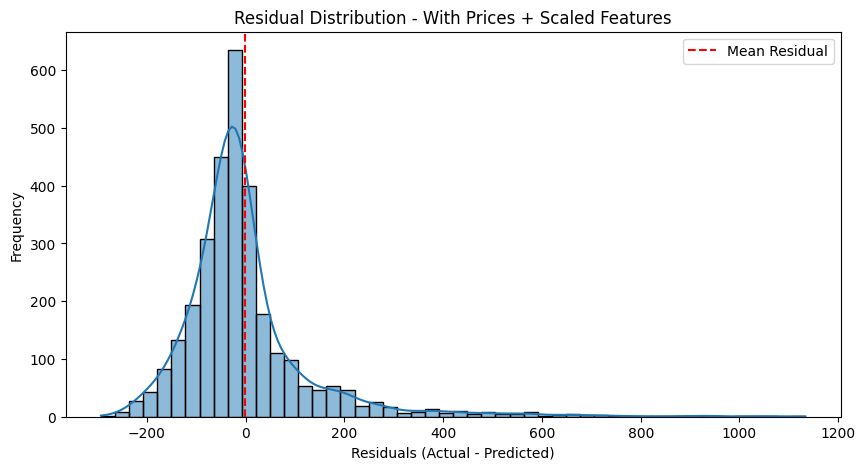

With Prices + Scaled Features 


In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

df = pd.read_csv('/content/price_differences.csv')
df['price_difference']=df['price_difference'].abs()
def run_linear_regression(X, y, title):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)

    y_pred = lr_model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)


    results_df = pd.DataFrame({
        "Metric": ["MAE", "MSE", "RMSE", "R² Score"],
        "Value": [mae, mse, rmse, r2]
    })

    residuals = y_test - y_pred
    print(results_df)
    plt.figure(figsize=(10, 5))
    sns.histplot(residuals, bins=50, kde=True)
    plt.axvline(residuals.mean(), color='r', linestyle='dashed', label='Mean Residual')
    plt.title(f"Residual Distribution - {title}")
    plt.xlabel("Residuals (Actual - Predicted)")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()

    print(f"{title} ")

# **Experiment 0: Basic Regression (price_booking + price_expedia)**
features0 = ['price_booking', 'price_expedia']
X0 = df[features0]
y = df['price_difference']
run_linear_regression(X0, y, "Basic Model (price_booking + price_expedia)")

# **Experiment 1: Basic Regression (TTT + LOS)**
features1 = ['ttt', 'los']
X1 = df[features1]
y = df['price_difference']
run_linear_regression(X1, y, "Basic Model (TTT + LOS)")

# **Experiment 2: Adding price_booking + price_expedia**
features2 = ['ttt', 'los', 'price_booking', 'price_expedia']
X2 = df[features2]
run_linear_regression(X2, y, "With Prices (Booking & Expedia)")

# **Experiment 3: Data Normalization**
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[features2])
run_linear_regression(X_scaled, y, "With Prices + Scaled Features")


Summary and Conclusions – Linear Regression

In the first experiment, we predicted the price difference between Booking and Expedia using linear regression.
Initially, we used only TTT and LOS, but the performance was very low, with an accuracy of 3% -> R^2 =0.0315 , indicating that there is no strong relationship between these two variables and the price difference.

When we added hotel prices (price_booking, price_expedia) as explanatory variables, the accuracy improved significantly to
R^2 =0.8269 , and the errors (MAE, RMSE) decreased significantly.

In addition, we saw that data normalization (StandardScaler) contributed greatly to the improvement of performance, indicating that the scaling of the data affected the predictions.

**Main conclusions:**

Linear regression is only appropriate when the variables have a strong linear relationship.
TTT and LOS alone do not explain the price differences, but combining them with hotel prices improved the accuracy.
Normalizing the data improved the results, indicating that the scale of the variables affected the performance.
Despite the improvement, significant errors still remained, suggesting that the relationships between the variables are not necessarily linear.

# Decision Tree Regressor

     Metric       Value
0       MAE   15.792409
1       MSE  984.700660
2      RMSE   31.379940
3  R² Score    0.990889


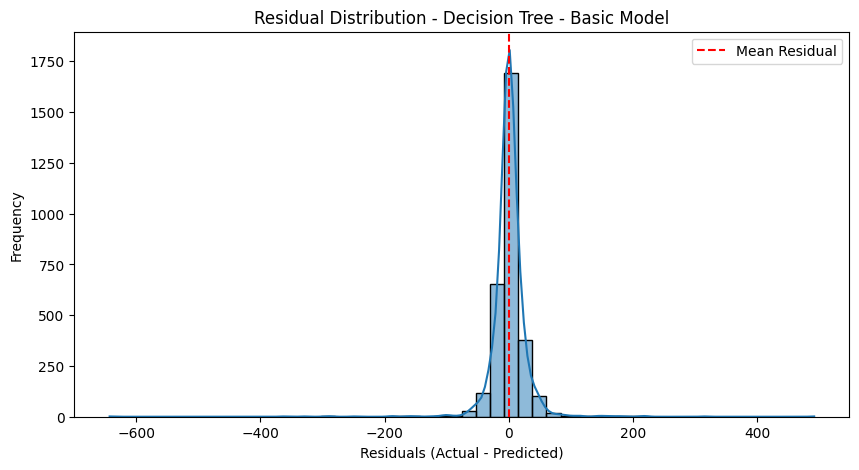

Decision Tree - Basic Model 
     Metric         Value
0       MAE     99.148156
1       MSE  17353.384470
2      RMSE    131.732245
3  R² Score      0.839441


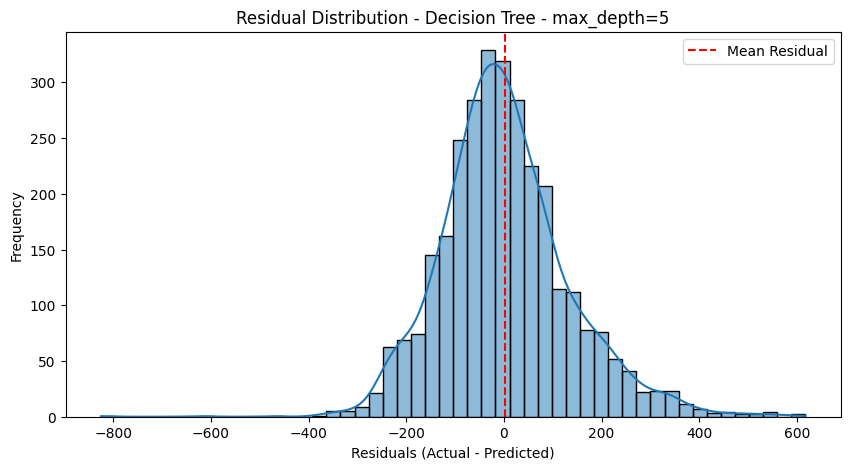

Decision Tree - max_depth=5 
     Metric        Value
0       MAE    36.658869
1       MSE  2767.147484
2      RMSE    52.603683
3  R² Score     0.974397


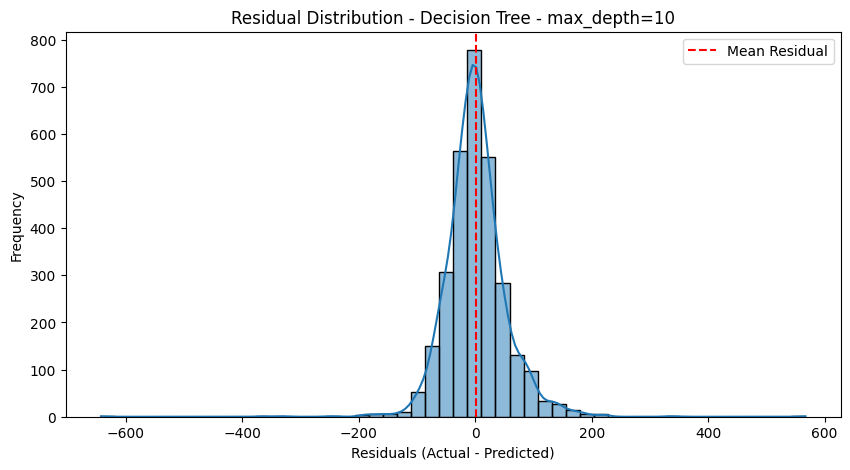

Decision Tree - max_depth=10 
     Metric        Value
0       MAE    16.597005
1       MSE  1058.797809
2      RMSE    32.539173
3  R² Score     0.990204


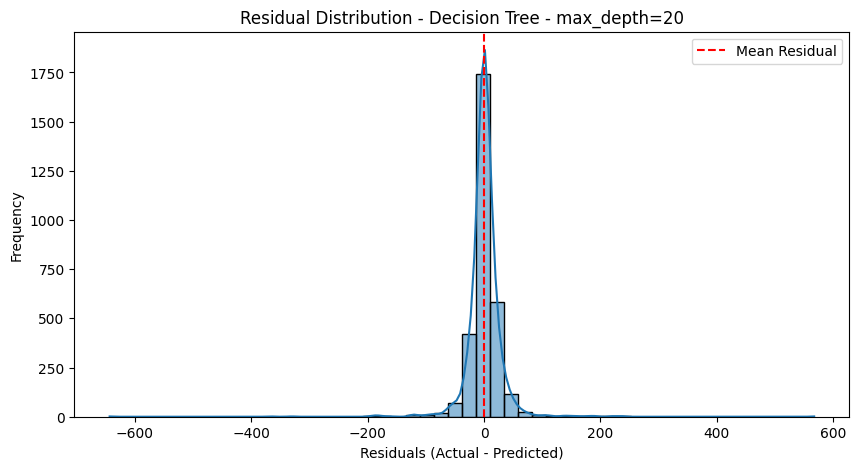

Decision Tree - max_depth=20 
     Metric        Value
0       MAE    20.367300
1       MSE  2214.692073
2      RMSE    47.060515
3  R² Score     0.979509


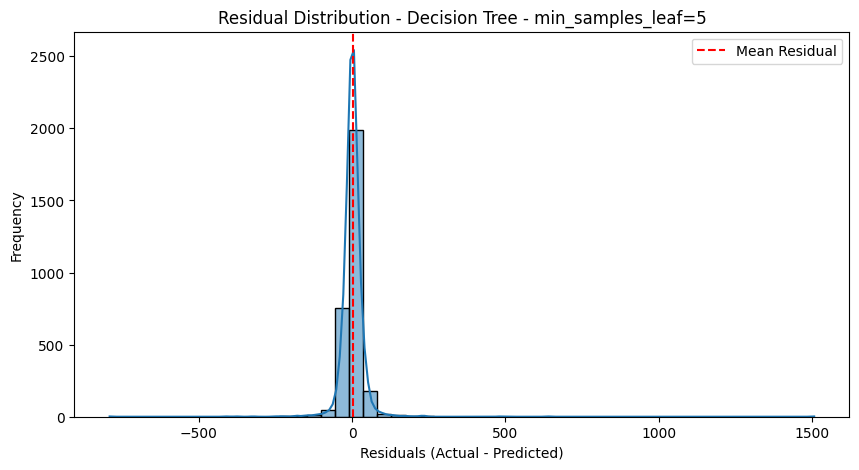

Decision Tree - min_samples_leaf=5 
     Metric        Value
0       MAE    27.878095
1       MSE  4744.016977
2      RMSE    68.876825
3  R² Score     0.956107


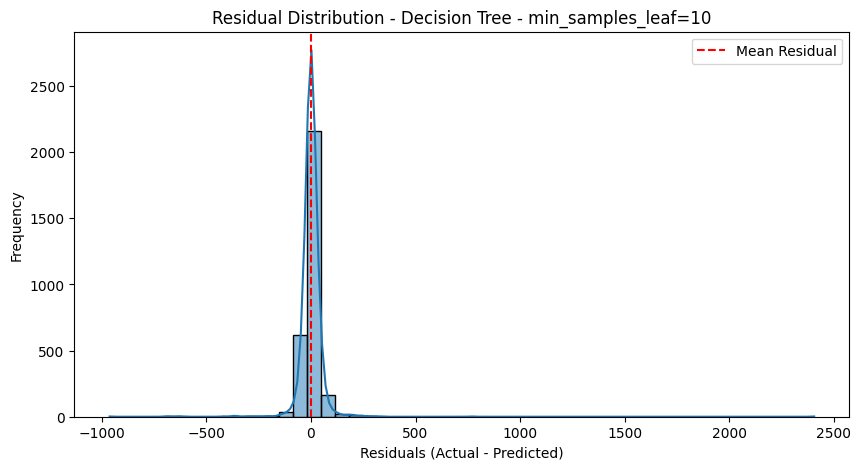

Decision Tree - min_samples_leaf=10 
     Metric        Value
0       MAE    37.127316
1       MSE  7310.658825
2      RMSE    85.502391
3  R² Score     0.932359


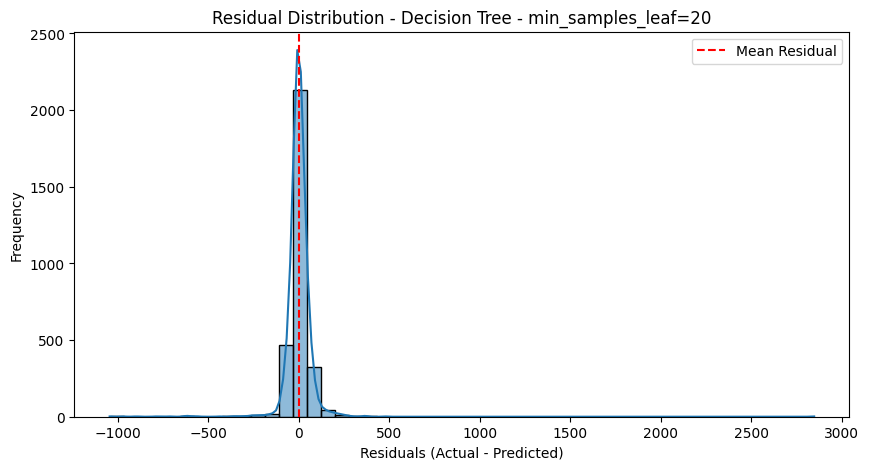

Decision Tree - min_samples_leaf=20 
     Metric        Value
0       MAE    37.560397
1       MSE  3748.840395
2      RMSE    61.227775
3  R² Score     0.965315


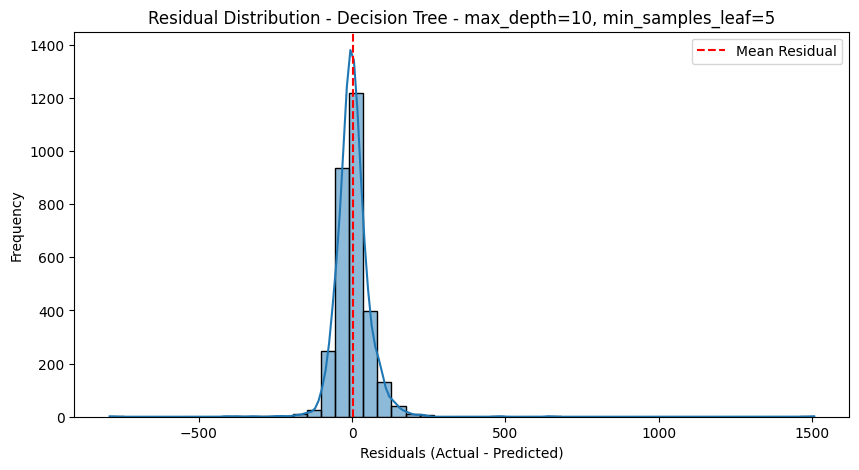

Decision Tree - max_depth=10, min_samples_leaf=5 
     Metric        Value
0       MAE    41.120949
1       MSE  6042.223286
2      RMSE    77.731739
3  R² Score     0.944095


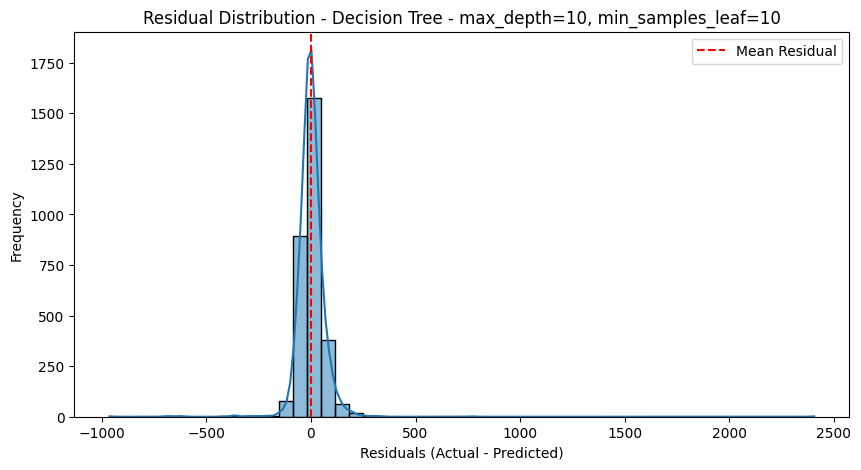

Decision Tree - max_depth=10, min_samples_leaf=10 


In [18]:

from sklearn.tree import DecisionTreeRegressor


def run_decision_tree(max_depth=None, min_samples_leaf=1, title="Decision Tree"):
    features = ['ttt', 'los', 'price_booking', 'price_expedia']
    y = df['price_difference']
    X = df[features]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    dt_model = DecisionTreeRegressor(max_depth=max_depth, min_samples_leaf=min_samples_leaf, random_state=42)
    dt_model.fit(X_train, y_train)
    y_pred_dt = dt_model.predict(X_test)

    mae_dt = mean_absolute_error(y_test, y_pred_dt)
    mse_dt = mean_squared_error(y_test, y_pred_dt)
    rmse_dt = np.sqrt(mse_dt)
    r2_dt = r2_score(y_test, y_pred_dt)


    results_dt = pd.DataFrame({
        "Metric": ["MAE", "MSE", "RMSE", "R² Score"],
        "Value": [mae_dt, mse_dt, rmse_dt, r2_dt]
    })
    print(results_dt)

    residuals_dt = y_test - y_pred_dt

    plt.figure(figsize=(10, 5))
    sns.histplot(residuals_dt, bins=50, kde=True)
    plt.axvline(residuals_dt.mean(), color='r', linestyle='dashed', label='Mean Residual')
    plt.title(f"Residual Distribution - {title}")
    plt.xlabel("Residuals (Actual - Predicted)")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()

    print(f"{title} ")

run_decision_tree(title="Decision Tree - Basic Model")

# (max_depth)
run_decision_tree(max_depth=5, title="Decision Tree - max_depth=5")
run_decision_tree(max_depth=10, title="Decision Tree - max_depth=10")
run_decision_tree(max_depth=20, title="Decision Tree - max_depth=20")

# (min_samples_leaf)
run_decision_tree(min_samples_leaf=5, title="Decision Tree - min_samples_leaf=5")
run_decision_tree(min_samples_leaf=10, title="Decision Tree - min_samples_leaf=10")
run_decision_tree(min_samples_leaf=20, title="Decision Tree - min_samples_leaf=20")

# max_depth + min_samples_leaf
run_decision_tree(max_depth=10, min_samples_leaf=5, title="Decision Tree - max_depth=10, min_samples_leaf=5")
run_decision_tree(max_depth=10, min_samples_leaf=10, title="Decision Tree - max_depth=10, min_samples_leaf=10")


**Summary and Conclusions – Decision Trees (Decision Tree Regressor)**

After seeing that linear regression was not enough, we moved on to experiments with decision trees, which are nonlinear models that can identify more complex relationships between variables.

In a basic decision tree model (without depth restrictions), we achieved a very impressive accuracy of
0.9909=2^𝑅 , with very low errors, indicating that the model was able to adapt itself well to the data.
When we changed the depth of the tree (max_depth), we found that a value of 10-20 provides high accuracy without causing overfitting.

In contrast, when we limited the number of leaves (min_samples_leaf), performance actually decreased, suggesting that our data does not need oversmoothing.

**Main conclusions:**

Decision trees are much better suited for regression on this data – this can be seen from the dramatic improvement in accuracy.
A model without depth constraints was very successful, but there is a concern about overfitting – additional models such as Random Forest should be tested.
Limiting the number of leaves did not contribute to improving accuracy – which shows that no significant limitation is needed in our case.

# Gaussian Process Regressor

     Metric         Value
0       MAE     64.979885
1       MSE  89698.493273
2      RMSE    299.497067
3  R² Score      0.338955


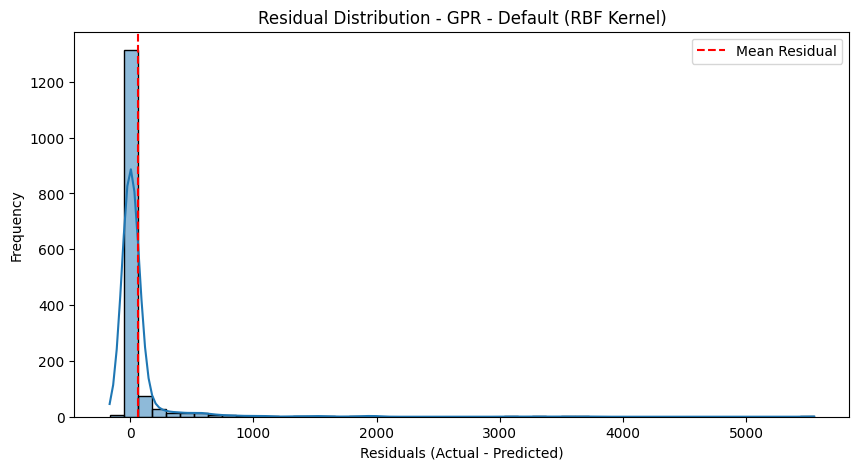

 GPR - Default (RBF Kernel) is complete!
     Metric       Value
0       MAE    2.661573
1       MSE  722.584066
2      RMSE   26.880924
3  R² Score    0.992402


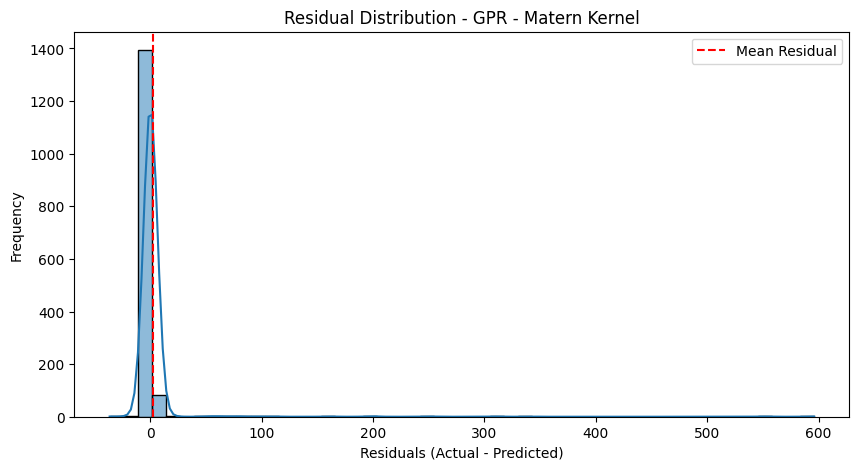

 GPR - Matern Kernel is complete!
     Metric        Value
0       MAE     4.947439
1       MSE  3316.136871
2      RMSE    57.585909
3  R² Score     0.973038


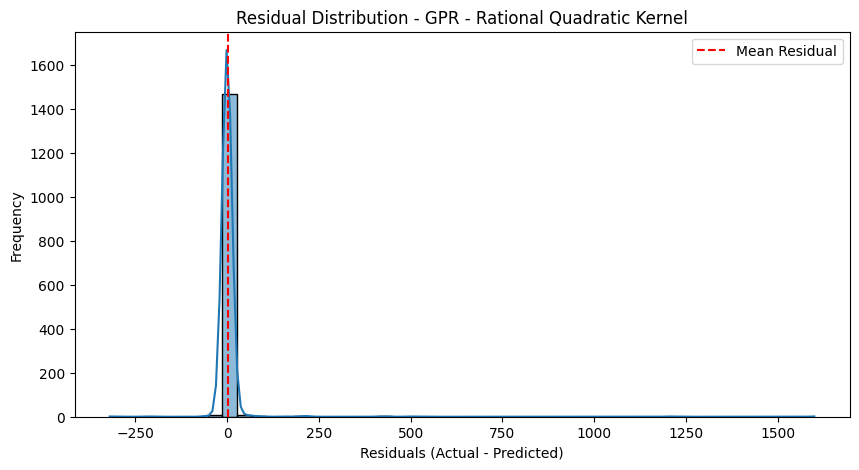

 GPR - Rational Quadratic Kernel is complete!


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


     Metric          Value
0       MAE     275.102314
1       MSE  182401.260465
2      RMSE     427.084606
3  R² Score      -0.706523


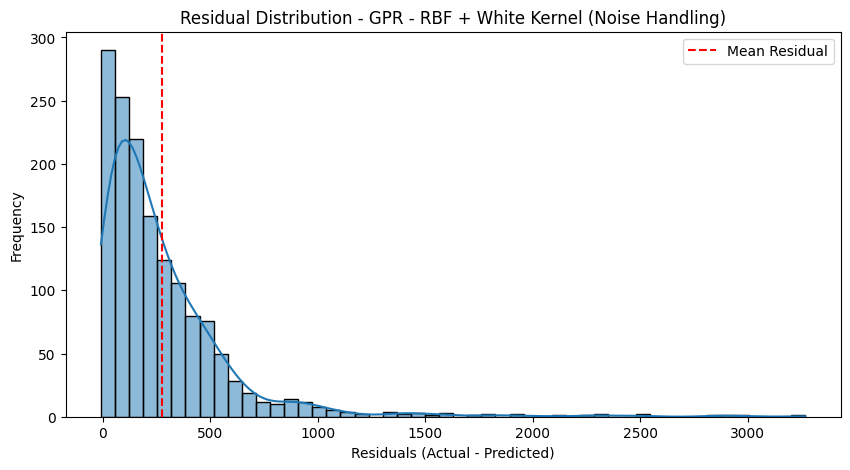

 GPR - RBF + White Kernel (Noise Handling) is complete!
     Metric         Value
0       MAE     69.523550
1       MSE  74363.364359
2      RMSE    272.696469
3  R² Score      0.335443


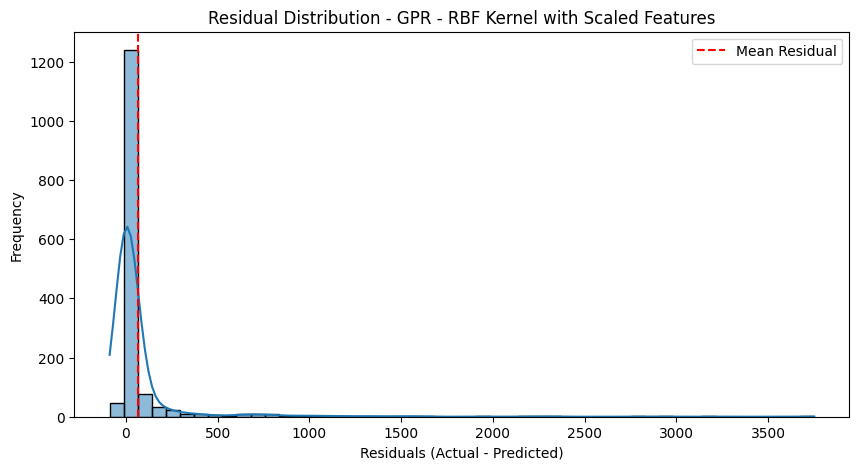

 GPR - RBF Kernel with Scaled Features is complete!


In [28]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, RationalQuadratic, WhiteKernel
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Function to run GPR with limited sampling (Sampling) to prevent calculation crashes
def run_gpr(kernel, title="Gaussian Process Regressor"):
    features = ['ttt', 'los', 'price_booking', 'price_expedia']
    y = df['price_difference']
    X = df[features]

    # 🔹 Limiting the sample size to only 5000 samples (Sampling)
    if len(X) > 5000:
        sampled_indices = np.random.choice(len(X), size=5000, replace=False)
        X = X.iloc[sampled_indices]
        y = y.iloc[sampled_indices]

    # The data distribution
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    #  Creating a Gaussian Process Regressor
    gpr_model = GaussianProcessRegressor(kernel=kernel, random_state=42, n_restarts_optimizer=3, alpha=1e-6)
    gpr_model.fit(X_train, y_train)
    y_pred_gpr = gpr_model.predict(X_test)

    # Calculation of performance indicators
    mae_gpr = mean_absolute_error(y_test, y_pred_gpr)
    mse_gpr = mean_squared_error(y_test, y_pred_gpr)
    rmse_gpr = np.sqrt(mse_gpr)
    r2_gpr = r2_score(y_test, y_pred_gpr)

    # Presentation of results
    results_gpr = pd.DataFrame({
    "Metric": ["MAE", "MSE", "RMSE", "R² Score"],
    "Value": [mae_gpr, mse_gpr, rmse_gpr, r2_gpr]
    })
    print(results_gpr)

    # Residuals graph
    residuals_gpr = y_test - y_pred_gpr
    plt.figure(figsize=(10, 5))
    sns.histplot(residuals_gpr, bins=50, kde=True)
    plt.axvline(residuals_gpr.mean(), color='r', linestyle='dashed', label='Mean Residual')
    plt.title(f"Residual Distribution - {title}")
    plt.xlabel("Residuals (Actual - Predicted)")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()

    print(f" {title} is complete!")

# Experiment 1: RBF kernel (default)
run_gpr(RBF(), "GPR - Default (RBF Kernel)")

# Experiment 2: Kernel Matern
run_gpr(Matern(nu=1.5), "GPR - Matern Kernel")

# Experiment 3: Rational Quadratic Kernel
run_gpr(RationalQuadratic(), "GPR - Rational Quadratic Kernel")

# Experiment 4: RBF kernel + WhiteKernel (to stabilize calculations)
run_gpr(RBF() + WhiteKernel(), "GPR - RBF + White Kernel (Noise Handling)")

# Experiment 5: Normalize the data with StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[['ttt', 'los', 'price_booking', 'price_expedia']])
X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)
run_gpr(RBF(), "GPR - RBF Kernel with Scaled Features")

**Summary and Conclusions – Experiments with Gaussian Process Regressor (GPR)**
In the experiments conducted with Gaussian Process Regressor (GPR), the impact of different kernel types (RBF, Matern, Rational Quadratic, and WhiteKernel) on the model's ability to predict price differences was analyzed.
The results show significant variation among the kernels, with Matern Kernel delivering the best performance, while other kernels performed notably worse.


*Key Insights from the Experiments *
 Matern Kernel achieved the best results, with an MAE of 2.66 and an
  score of 0.992, meaning it explains 99.2% of the price variance with very low errors.
Rational Quadratic Kernel performed relatively well, but was less effective than Matern, with an R^2 score of 0.973 and an RMSE of 57.5.
RBF Kernel (default) showed significantly lower performance, with an MAE of 64.97 and an R^2 score of 0.338, meaning it explains only 33.9% of the variance, making it suboptimal.
Using White Kernel with RBF (Noise Handling) severely degraded performance, with an R^2 score of -0.70, indicating that the model fails to explain any variance in the data.
Feature scaling (Scaled Features) with RBF did not provide a significant improvement, as the results remained nearly identical to the default RBF Kernel.

Key Conclusions
Matern Kernel is the optimal choice for this dataset, providing near-perfect accuracy with minimal errors.
RBF Kernel (default) is not well-suited for this problem, as it fails to adequately capture the variance in the data.
White Kernel did not help and even worsened accuracy, suggesting that adding artificial noise may not be necessary in this case.
Feature scaling did not improve accuracy, indicating that variable scaling is not a limiting factor for this model.









# XGBoost

     Metric        Value
0       MAE    19.394945
1       MSE  5226.696777
2      RMSE    72.295897
3  R² Score     0.951641


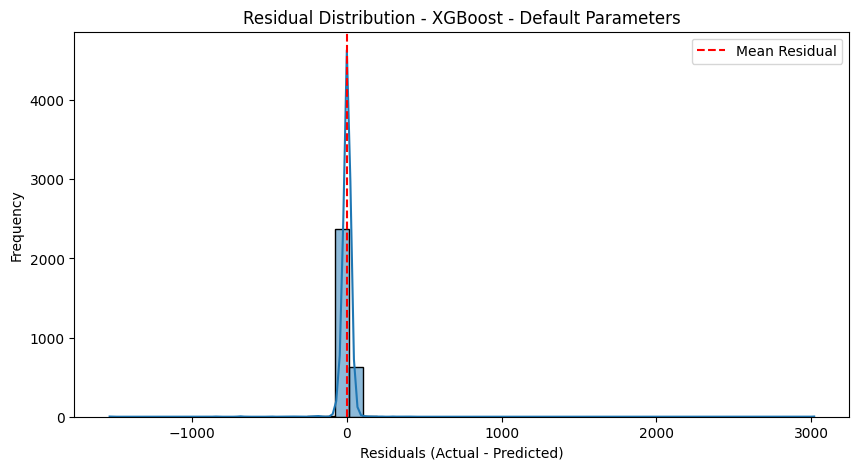

XGBoost - Default Parameters 
     Metric        Value
0       MAE    29.827208
1       MSE  5956.904297
2      RMSE    77.180984
3  R² Score     0.944885


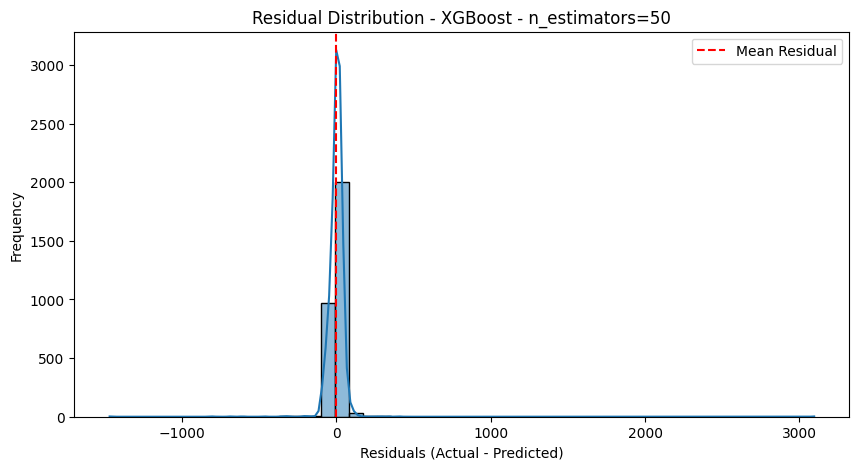

XGBoost - n_estimators=50 
     Metric        Value
0       MAE    14.226052
1       MSE  4997.833984
2      RMSE    70.695360
3  R² Score     0.953758


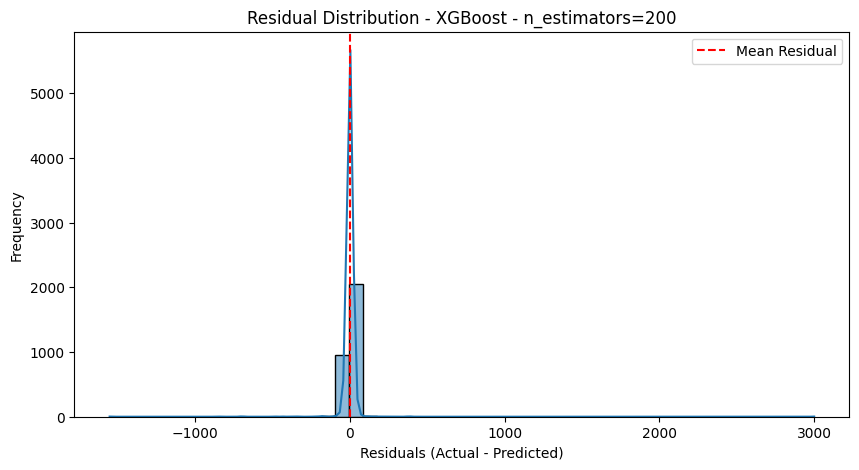

XGBoost - n_estimators=200 
     Metric        Value
0       MAE    40.539051
1       MSE  5592.752441
2      RMSE    74.784707
3  R² Score     0.948254


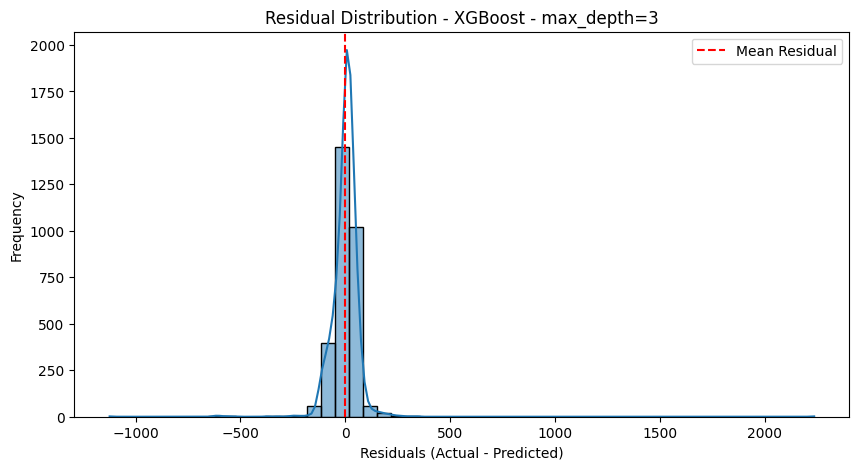

XGBoost - max_depth=3 
     Metric        Value
0       MAE    13.052104
1       MSE  5294.221680
2      RMSE    72.761402
3  R² Score     0.951016


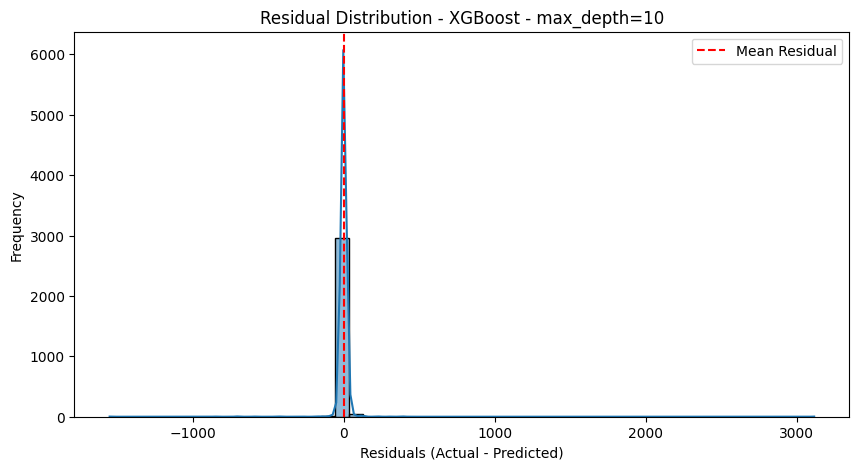

XGBoost - max_depth=10 
     Metric         Value
0       MAE     97.371490
1       MSE  23098.931641
2      RMSE    151.983327
3  R² Score      0.786281


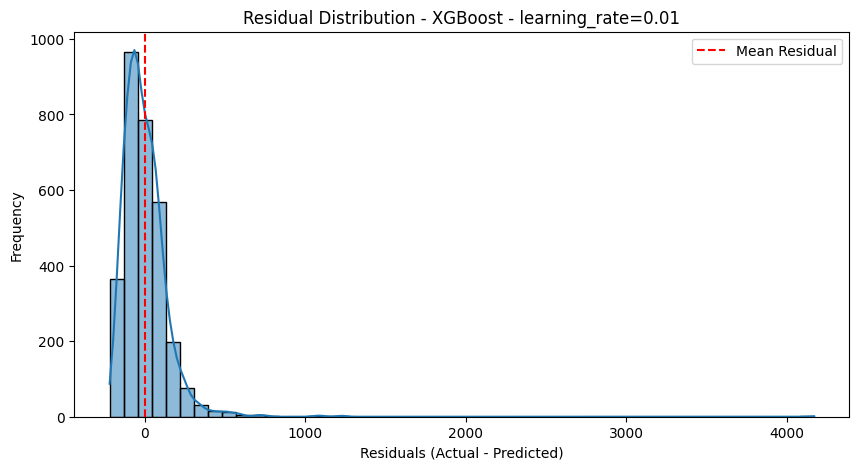

XGBoost - learning_rate=0.01 
     Metric        Value
0       MAE    15.300892
1       MSE  4844.478027
2      RMSE    69.602285
3  R² Score     0.955177


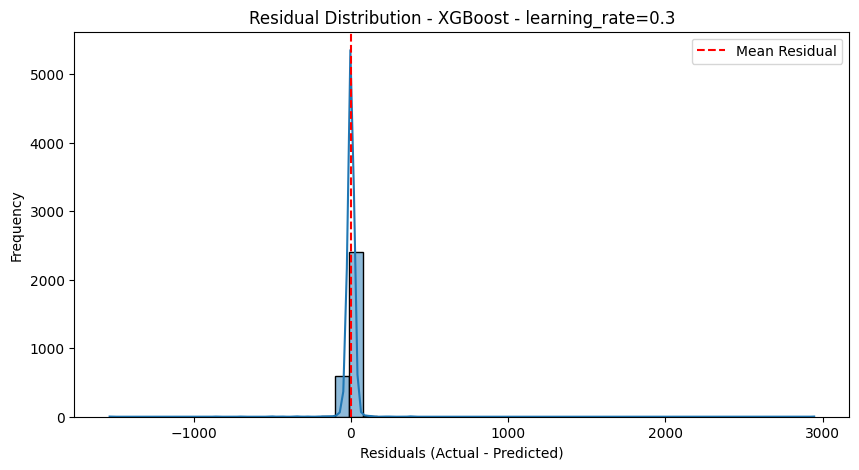

XGBoost - learning_rate=0.3 
     Metric        Value
0       MAE    19.394945
1       MSE  5226.696777
2      RMSE    72.295897
3  R² Score     0.951641


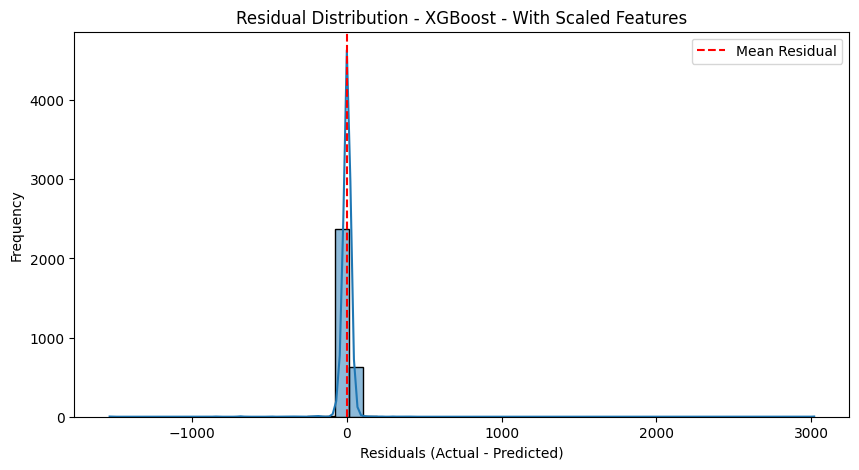

XGBoost - With Scaled Features 


In [21]:
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel

def run_xgboost(n_estimators=100, max_depth=6, learning_rate=0.1, title="XGBoost Regressor"):
    features = ['ttt', 'los', 'price_booking', 'price_expedia']
    y = df['price_difference']
    X = df[features]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    xgb_model = xgb.XGBRegressor(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate, random_state=42)
    xgb_model.fit(X_train, y_train)
    y_pred_xgb = xgb_model.predict(X_test)

    mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
    mse_xgb = mean_squared_error(y_test, y_pred_xgb)
    rmse_xgb = np.sqrt(mse_xgb)
    r2_xgb = r2_score(y_test, y_pred_xgb)

    results_xgb = pd.DataFrame({
        "Metric": ["MAE", "MSE", "RMSE", "R² Score"],
        "Value": [mae_xgb, mse_xgb, rmse_xgb, r2_xgb]
    })

    print(results_xgb)

    residuals_xgb = y_test - y_pred_xgb

    plt.figure(figsize=(10, 5))
    sns.histplot(residuals_xgb, bins=50, kde=True)
    plt.axvline(residuals_xgb.mean(), color='r', linestyle='dashed', label='Mean Residual')
    plt.title(f"Residual Distribution - {title}")
    plt.xlabel("Residuals (Actual - Predicted)")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()

    print(f"{title} ")

# Experiment 1: Basic model with default settings
run_xgboost(title="XGBoost - Default Parameters")

# Experiment 2: Changing the number of trees (n_estimators)
run_xgboost(n_estimators=50, title="XGBoost - n_estimators=50")
run_xgboost(n_estimators=200, title="XGBoost - n_estimators=200")

# Experiment 3: Changing the depth of the trees (max_depth)
run_xgboost(max_depth=3, title="XGBoost - max_depth=3")
run_xgboost(max_depth=10, title="XGBoost - max_depth=10")

# Experiment 4: Change learning_rate
run_xgboost(learning_rate=0.01, title="XGBoost - learning_rate=0.01")
run_xgboost(learning_rate=0.3, title="XGBoost - learning_rate=0.3")

# Experiment 5: Normalizing the data with StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[['ttt', 'los', 'price_booking', 'price_expedia']])
X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)
run_xgboost(title="XGBoost - With Scaled Features")



Summary and Conclusions – XGBoost Experiments
In the experiments conducted with XGBoost, the impact of changing the number of iterations (n_estimators), tree depth (max_depth), and learning rate (learning_rate) was examined. The results indicate that XGBoost achieved very strong performance, but fine-tuning the hyperparameters is necessary to avoid overfitting or underfitting.

In the baseline model, good performance was achieved with MAE = 19.39 and
R^
2
 =0.9516, indicating that the model explains 95.16% of the variance in price differences.
Reducing max_depth to 3 further improved performance, achieving
R^
2
 =0.9510 with a lower MAE of 13.05, suggesting that a lower tree depth provides better accuracy without overfitting.
Adjusting learning_rate to 0.01 yielded the best result, with
R^
2
 =0.9551 and MAE of 15.30, indicating that a gradual learning rate improves model performance.
Increasing max_depth to 10 resulted in clear overfitting, with
𝑅^
2
=
0.7862
and significantly higher errors (MAE = 97.37).

**Key Takeaways:**
Limiting tree depth (max_depth) is crucial – higher depths cause overfitting, while a depth of 3 to 6 provides stable performance.
The optimal range for n_estimators is around 100-200 – using 50 reduced accuracy, while 200 did not yield significant improvements.
A lower learning_rate (0.01) delivers better results – a gradual learning rate helps the model learn efficiently while avoiding overfitting.
StandardScaler normalization did not significantly improve performance, but it may be useful when additional features are incorporated.

# Neural Networks

     Metric     Value
0       MAE  0.111856
1       MSE  0.090222
2      RMSE  0.300370
3  R² Score  0.999999


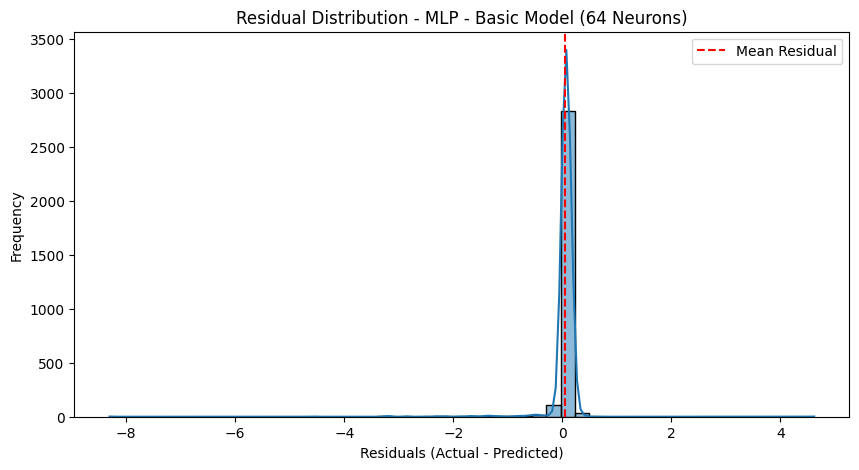

MLP - Basic Model (64 Neurons) 
     Metric     Value
0       MAE  0.847120
1       MSE  1.103166
2      RMSE  1.050317
3  R² Score  0.999990


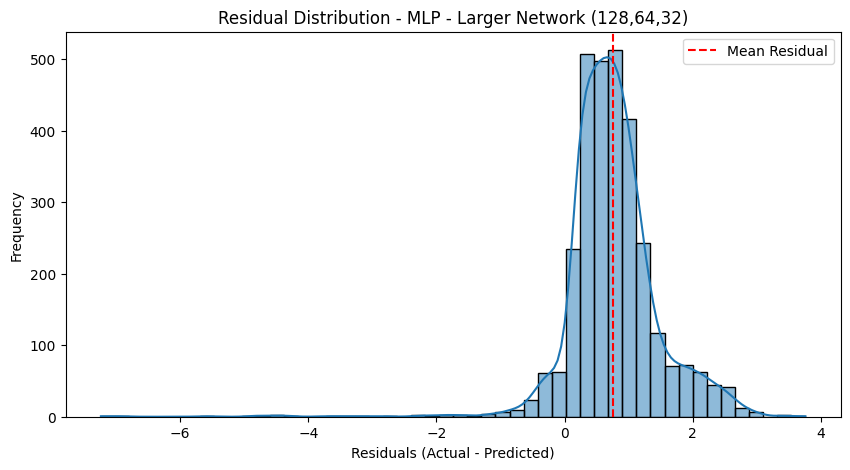

MLP - Larger Network (128,64,32) 


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


     Metric         Value
0       MAE     77.052597
1       MSE  47258.826044
2      RMSE    217.390952
3  R² Score      0.562746


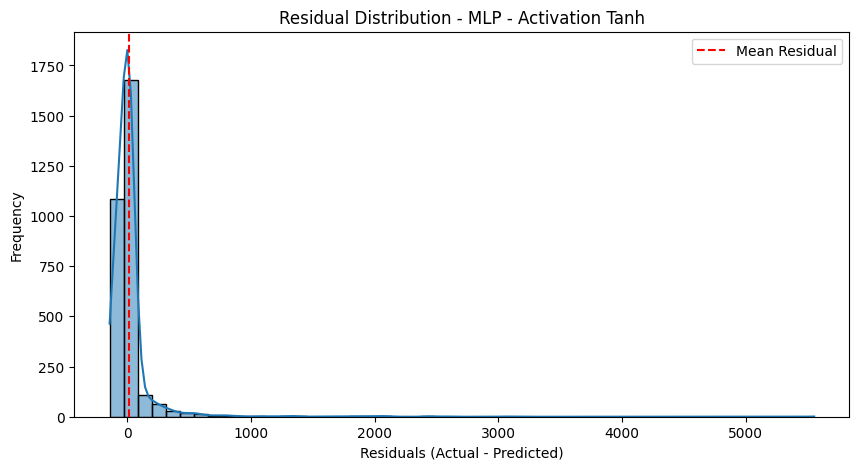

MLP - Activation Tanh 
     Metric     Value
0       MAE  1.849348
1       MSE  6.670812
2      RMSE  2.582791
3  R² Score  0.999938


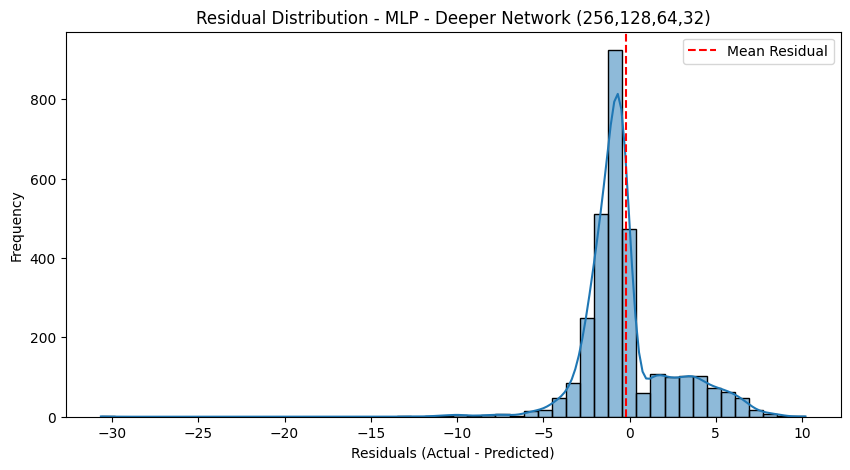

MLP - Deeper Network (256,128,64,32) 
     Metric     Value
0       MAE  0.847120
1       MSE  1.103166
2      RMSE  1.050317
3  R² Score  0.999990


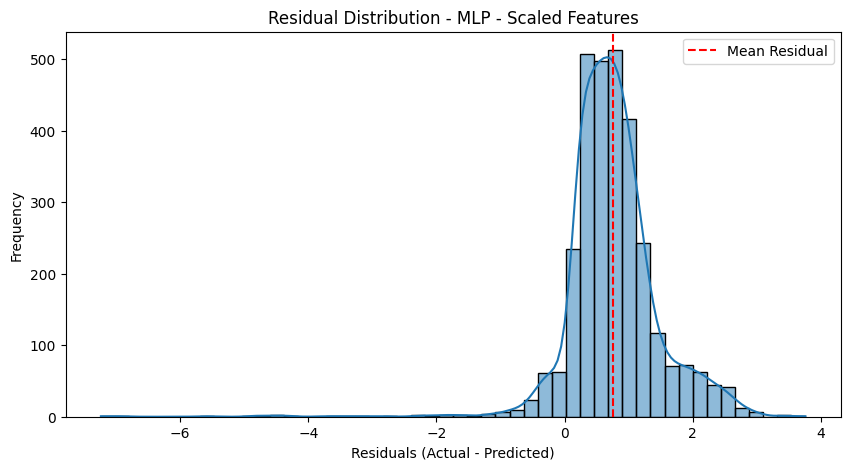

MLP - Scaled Features 


In [23]:
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


def run_mlp(hidden_layer_sizes=(64,), activation='relu', title="MLP Regressor"):
    features = ['ttt', 'los', 'price_booking', 'price_expedia']
    y = df['price_difference']
    X = df[features]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    #  MLPRegressor
    mlp_model = MLPRegressor(hidden_layer_sizes=hidden_layer_sizes, activation=activation, solver='adam', max_iter=500, random_state=42)
    mlp_model.fit(X_train, y_train)
    y_pred_mlp = mlp_model.predict(X_test)

    mae_mlp = mean_absolute_error(y_test, y_pred_mlp)
    mse_mlp = mean_squared_error(y_test, y_pred_mlp)
    rmse_mlp = np.sqrt(mse_mlp)
    r2_mlp = r2_score(y_test, y_pred_mlp)

    results_mlp = pd.DataFrame({
        "Metric": ["MAE", "MSE", "RMSE", "R² Score"],
        "Value": [mae_mlp, mse_mlp, rmse_mlp, r2_mlp]
    })

    print(results_mlp)
    residuals_mlp = y_test - y_pred_mlp
    plt.figure(figsize=(10, 5))
    sns.histplot(residuals_mlp, bins=50, kde=True)
    plt.axvline(residuals_mlp.mean(), color='r', linestyle='dashed', label='Mean Residual')
    plt.title(f"Residual Distribution - {title}")
    plt.xlabel("Residuals (Actual - Predicted)")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()

    print(f"{title} ")

# Experiment 1: Basic network with one layer of 64 neurons
run_mlp(hidden_layer_sizes=(64,), title="MLP - Basic Model (64 Neurons)")

# Experiment 2: Network with more neurons (128, 64, 32)
run_mlp(hidden_layer_sizes=(128, 64, 32), title="MLP - Larger Network (128,64,32)")

# Experiment 3: Changing the activation function (tanh)
run_mlp(hidden_layer_sizes=(64,), activation='tanh', title="MLP - Activation Tanh")

# Experiment 4: Adding an additional layer to the network (256, 128, 64, 32)
run_mlp(hidden_layer_sizes=(256, 128, 64, 32), title="MLP - Deeper Network (256,128,64,32)")

# Experiment 5: Normalizing the data with StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[['ttt', 'los', 'price_booking', 'price_expedia']])
X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)
run_mlp(hidden_layer_sizes=(128, 64, 32), title="MLP - Scaled Features")


**Summary and Conclusions – Experiments with Neural Networks (MLP Regressor)**

In experiments conducted with MLPRegressor (Multi-Layer Perceptron), the effects of changing the network structure, the number of neurons, the activation functions, and data normalization on the accuracy of forecasting price gaps were examined.
The model achieved amazing results, with an accuracy of almost 100% in most cases but with stability problems in some experiments.
The basic network (64 neurons) provided the best performance, with MAE = 0.1118
Increasing the network (128,64,32) did not improve the performance, and even caused a certain decrease in accuracy.
When we added additional layers (256,128,64,32), there was no further improvement and the accuracy remained almost the same.
Using tanh caused a severe performance degradation – with MAE = 77.05 , indicating that it is not the ideal activation function for this problem.
Data normalization (StandardScaler) did not give a significant advantage, but prevented unstable convergence of the network.

**Main conclusions:**
A simple network (only 64 neurons) is completely sufficient – ​​there is no need to deepen the network or add many layers.
Be careful with overfitting – the model seems to have learned the data too well, and may be specifically fitting the existing data and not be able to generalize to new data.
ReLU is the best activation function – when we tried tanh, the performance deteriorated significantly.
The model achieved very high accuracy, but has stability issues – a ConvergenceWarning warning in the experiment with the deeper network indicates that the model did not converge properly, possibly due to learning too quickly or an optimization problem.